In [35]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 708.2 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 957.2/957.2 KB 640.1 kB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 609.0 kB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2022-09-07 11:57:02.728149: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 11:57:02.728182: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/carlos/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
print(tf.__version__)

2.9.2


In [3]:
# dataset_url = "dataset/dataverse_files"
# data_dir = tf.keras.utils.get_file("maize_photos", origin=dataset_url)
import pathlib
data_dir = pathlib.Path("dataset/dataverse_files")

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6050


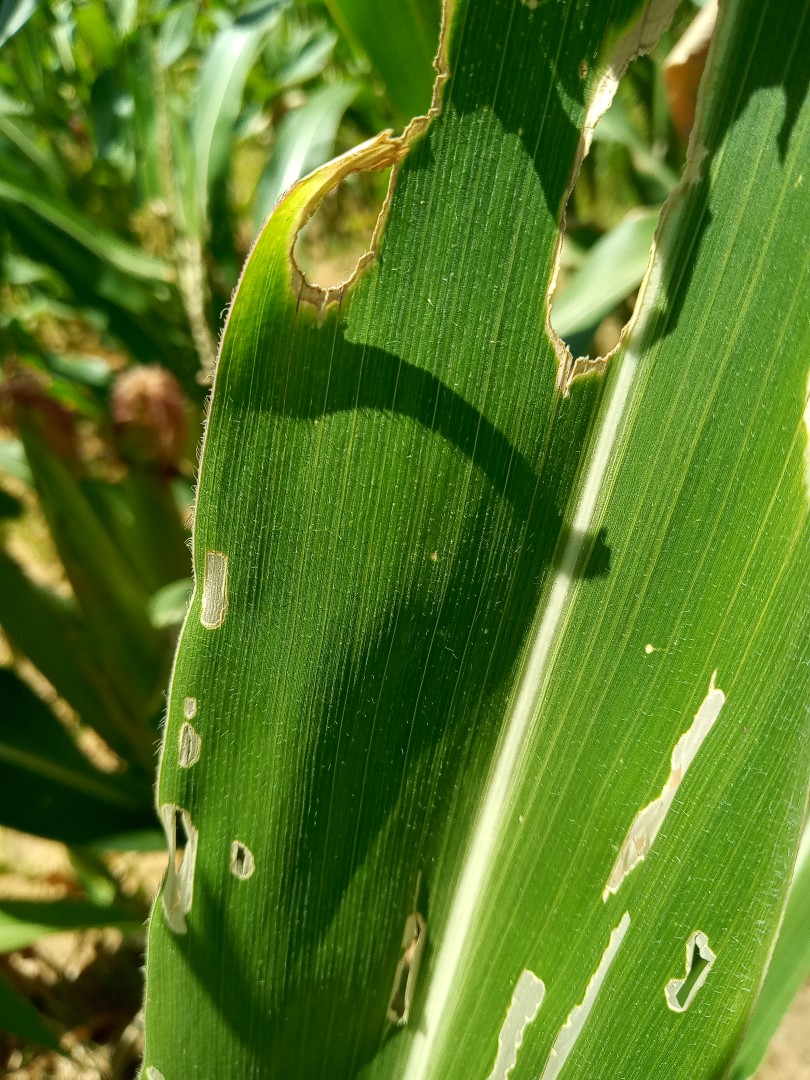

In [5]:
faw = list(data_dir.glob('FAW/*'))
Image.open(str(faw[0]))

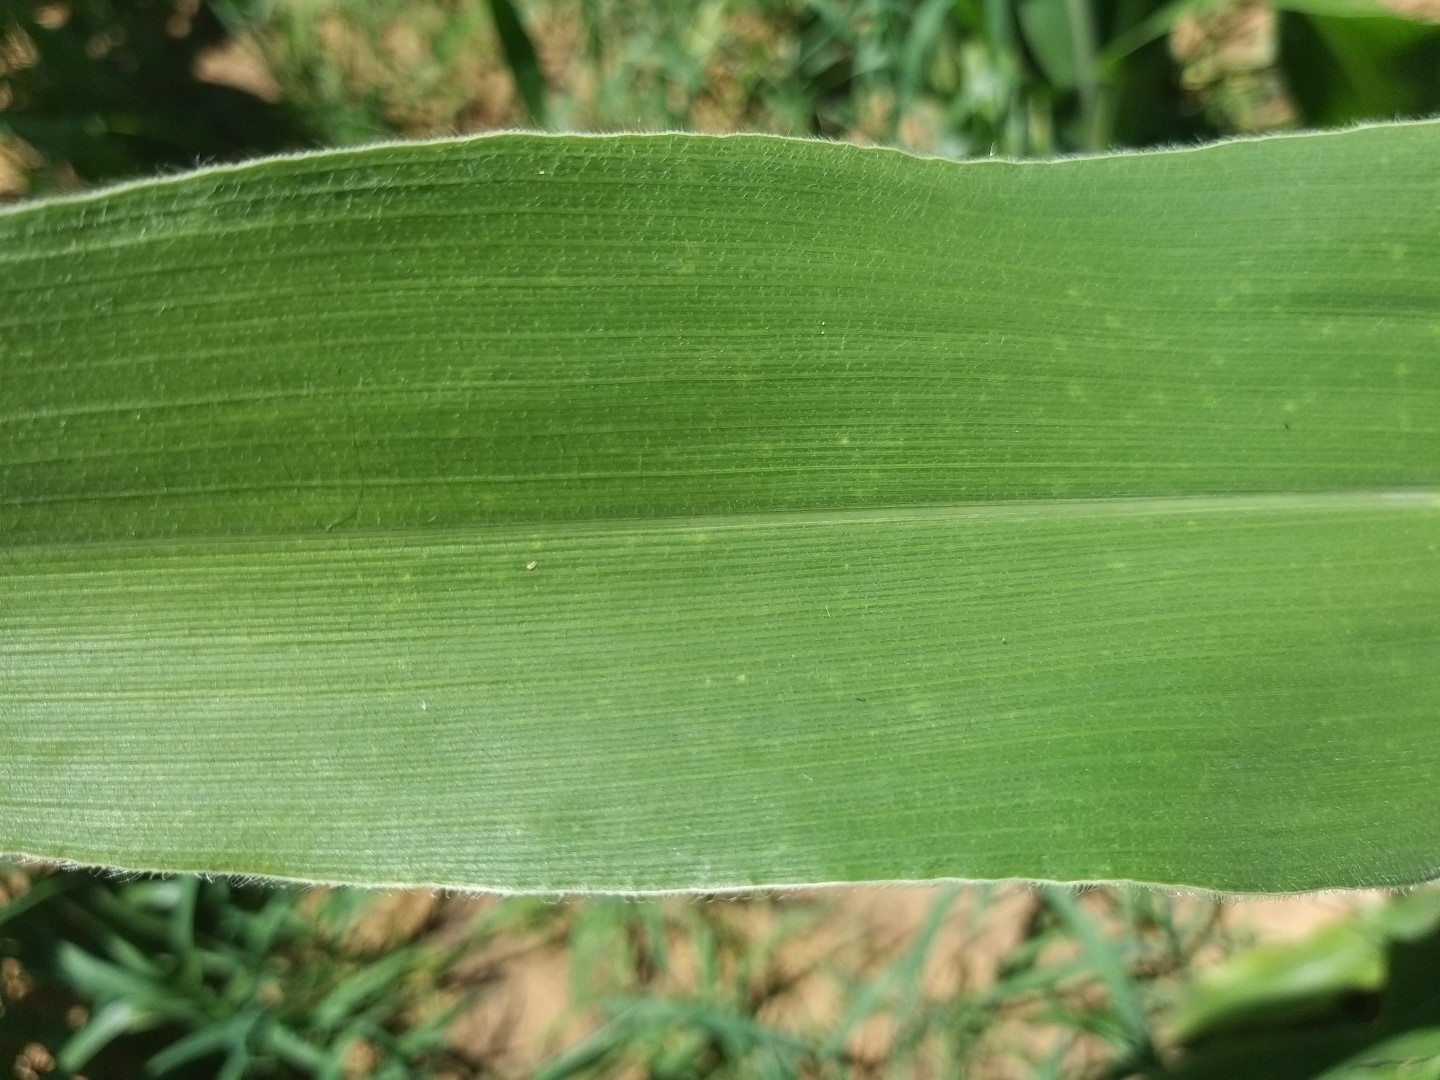

In [6]:
healthy = list(data_dir.glob('healthy/*'))
Image.open(str(healthy[0]))

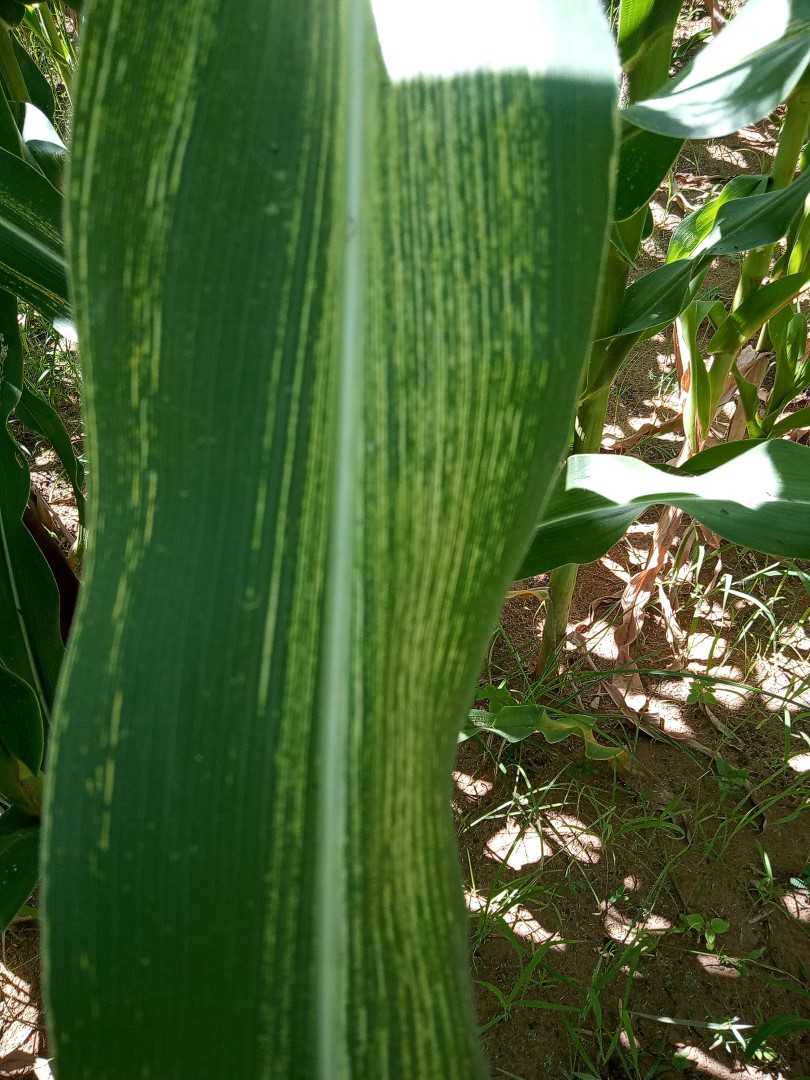

In [7]:
msv = list(data_dir.glob('MSV/*'))
Image.open(str(msv[0]))

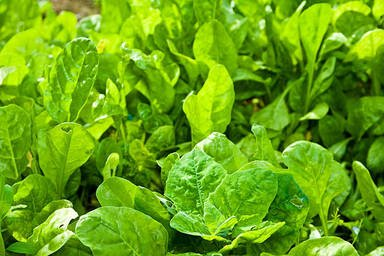

In [29]:
unknown = list(data_dir.glob('unknown/*'))
Image.open(str(unknown[0]))

In [30]:
batch_size = 32
img_height = 180
img_width = 180

In [31]:
# create the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="training",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)

Found 8090 files belonging to 4 classes.
Using 6472 files for training.


In [32]:
val_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="validation",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)

Found 8090 files belonging to 4 classes.
Using 1618 files for validation.


In [33]:
## find class names
class_names = train_ds.class_names
print(class_names)

['FAW', 'MSV', 'healthy', 'unknown']


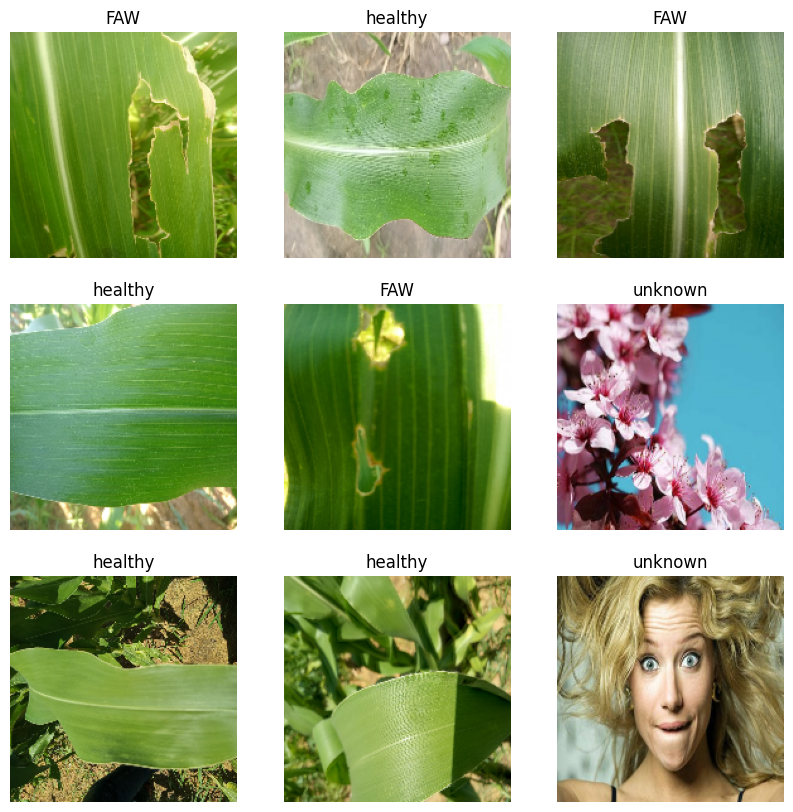

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [35]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [39]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
## Standardize the data
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [37]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99803925


In [38]:
## data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

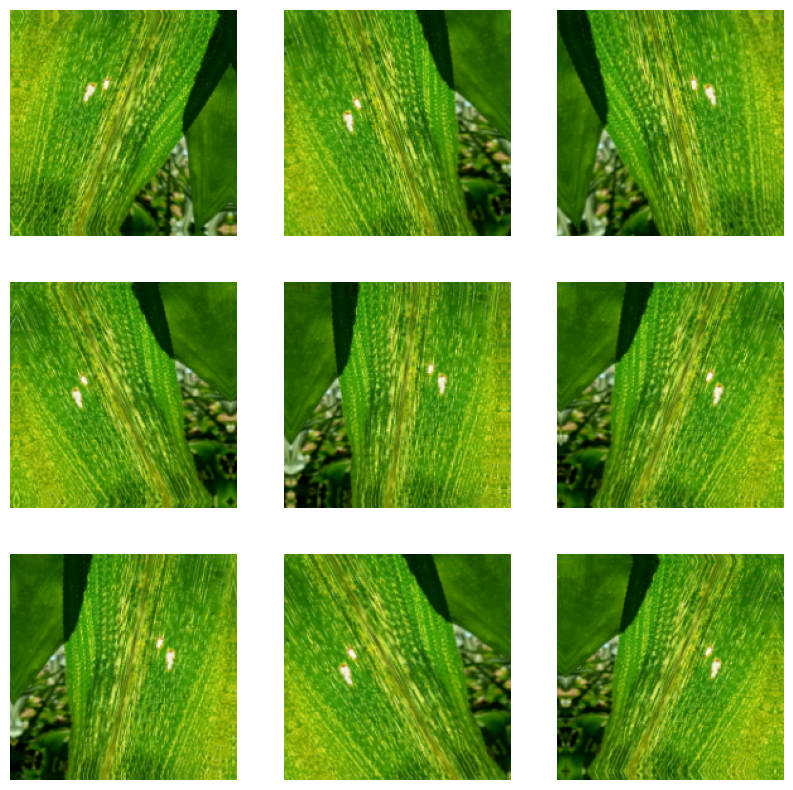

In [39]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [40]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [43]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
203/203 [==============================] - 156s 760ms/step - loss: 0.7384 - accuracy: 0.7058 - val_loss: 0.6588 - val_accuracy: 0.7515
Epoch 2/10
203/203 [==============================] - 156s 767ms/step - loss: 0.3790 - accuracy: 0.8625 - val_loss: 0.5579 - val_accuracy: 0.8053
Epoch 3/10
203/203 [==============================] - 159s 782ms/step - loss: 0.2894 - accuracy: 0.8972 - val_loss: 0.8181 - val_accuracy: 0.7800
Epoch 4/10
203/203 [==============================] - 159s 780ms/step - loss: 0.2426 - accuracy: 0.9136 - val_loss: 0.3542 - val_accuracy: 0.8801
Epoch 5/10
203/203 [==============================] - 160s 783ms/step - loss: 0.2147 - accuracy: 0.9237 - val_loss: 0.4186 - val_accuracy: 0.8776
Epoch 6/10
203/203 [==============================] - 159s 777ms/step - loss: 0.1850 - accuracy: 0.9367 - val_loss: 0.5286 - val_accuracy: 0.8473
Epoch 7/10
203/203 [==============================] - 159s 778ms/step - loss: 0.1576 - accuracy: 0.9442 - val_loss: 0.3053 -

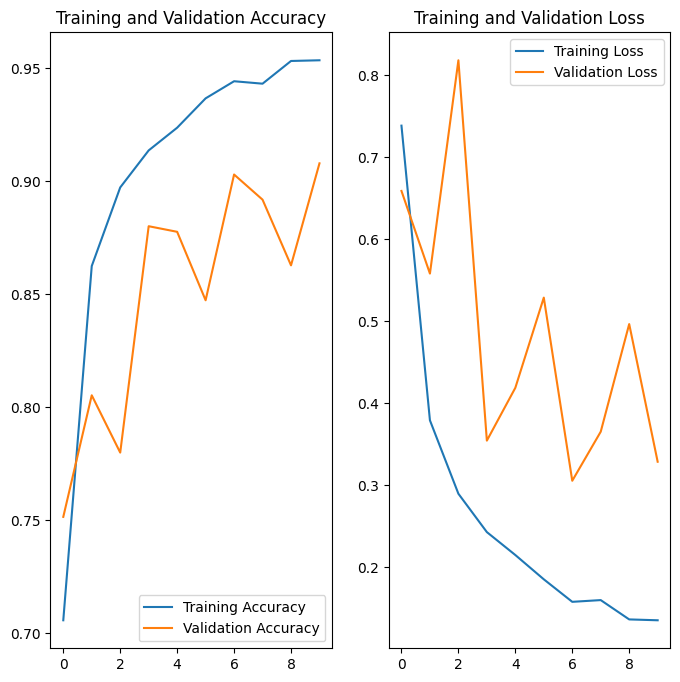

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [69]:
# trying to predict
img = tf.keras.utils.load_img(
"dataset/predict/dog.jpeg", target_size=(img_height,img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
# print(predictions)
score = tf.nn.softmax(predictions[0])
# print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 32ms/step
[[-6.8455343 -2.514008   0.5584649 16.760265 ]]
tf.Tensor([5.5992645e-11 4.2588231e-09 9.1970179e-08 9.9999988e-01], shape=(4,), dtype=float32)
This image most likely belongs to unknown with a 100.00 percent confidence.


In [72]:
## save the model
model.save('maize_model.h5')

In [74]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  